In [3]:
try:
    import pylibjpeg
except:
    #!mkdir -p /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    #!pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

Processing /kaggle/input/rsna-2022-whl/pydicom-2.3.0-py3-none-any.whl
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/kaggle/input/rsna-2022-whl/pydicom-2.3.0-py3-none-any.whl'



In [4]:
from pydicom import dcmread
from pydicom.pixel_data_handlers import pillow_handler
pillow_handler.PillowJPEGTransferSyntaxes.append('1.2.840.10008.1.2.4.70')

In [5]:
!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl

Processing /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


In [6]:
import dicomsdl as dicoml
import numpy as np 
import pandas as pd 
import tensorflow.keras as keras
import os
from multiprocess import Process, Manager
import gc
from tqdm import tqdm
import cv2
import glob
import time
import imageio as iio
#import gdcm
#import pydicom
import matplotlib.pyplot as plt
import pydicom
from pathlib import Path
from PIL import Image
import tensorflow.keras.layers as layers
import matplotlib.image as Img     
import PIL
from pydicom import dcmread
from joblib import Parallel, delayed
import tensorflow as tf
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.models import load_model
import random
import tensorflow_addons as tfa

2023-02-16 13:53:08.729482: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-16 13:53:08.729648: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# TPU

In [7]:
AUTO = tf.data.experimental.AUTOTUNE  #CLASS optimizer set to automatic

In [8]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

2023-02-16 13:53:16.401395: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-16 13:53:16.404552: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-16 13:53:16.404606: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-16 13:53:16.404632: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9af752e8db96): /proc/driver/nvidia/version does not exist
2023-02-16 13:53:16.407654: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of accelerators:  8


In [9]:
from kaggle_datasets import KaggleDatasets

In [10]:
import psutil
print(psutil.cpu_count(logical=True))

4


# MEtric

In [11]:
def pfbeta_tf(labels, preds, beta=1):
    eps = 1e-5
    preds = tf.clip_by_value(preds, 0, 1)
    y_true_count = tf.reduce_sum(labels)
    ctp = tf.reduce_sum(preds[labels==1])
    cfp = tf.reduce_sum(preds[labels==0])
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return tf.constant(0, dtype=tf.float32)
pfbeta_tf.__name__='pF1'


# finds best pf1 using thresholds
def pfbeta_thr(labels, preds):
    thrs = tf.range(0, 1, 0.05)
    best_score = tf.constant(0, dtype=tf.float32)
    for thr in thrs:
        score = pfbeta_tf(labels, tf.cast(preds>thr, tf.float32))
        best_score = tf.cond(score > best_score, lambda: score, lambda: best_score)
    return best_score

pfbeta_thr.__name__='pF1_thr'

def pfbeta(labels, preds, beta=1):
    eps = 1e-5
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return 0.0

In [12]:
train_csv = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

# Data Exportation

In [13]:
Caminho_base = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512'

In [17]:
GCS_PATH = KaggleDatasets().get_gcs_path(Caminho_base.split('/')[-3])

In [18]:
!gsutil ls $GCS_PATH

gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_1024/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_512/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_768/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_cv2_256/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_cv2_384/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_cv2_512/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_cv2_dicomsdl_256/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_cv2_dicomsdl_512/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_cv2_dicomsdl_768/
gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d69d02e8e4630f2f0e33/images_as_pngs_cv2_vl_256/

In [19]:
class CFG:
    DUBUG = False
    age = False
    seed = 42
    batch_size = 128
    Folds = 3
    img_size = (512,512)
    augment = 0.2
    pixel_aug = 0.3
    fill_mode = 'bilinear'
    bright = 0.2
    up = 0.2
    rot = 0.2
    # flip
    hflip = True
    vflip = True

    # clip
    clip = False

    # pixel-augment
    sat  = [0.9, 1.1]
    cont = [0.9, 1]
    bri  = 0.05
    hue  = 0.05

    # target column
    target_col  = ['cancer']

In [20]:
if CFG.DUBUG:
    train_csv['image_path'] = Caminho_base +'/'+\
                       + train_csv.patient_id.astype(str)\
                           + '/' + train_csv.image_id.astype(str)+ '.png'
else:
    train_csv['image_path'] = f'{GCS_PATH}/images_as_pngs_cv2_512'+ '/train_images_processed_cv2_512/'\
                       + train_csv.patient_id.astype(str)\
                           + '/' + train_csv.image_id.astype(str)+ '.png'

In [21]:
train_csv.image_path[0]
import cv2 as cv

In [22]:
# Make age usable
a = train_csv[train_csv['age'].isnull()]
#a.head()
train_csv['age'].fillna((train_csv['age'].mean()), inplace=True)
b = train_csv[train_csv['age'].isnull()]
#b.head()
# Normalize data
train_csv['age'] = train_csv['age']/train_csv['age'].max()
train_csv['age']

0        0.685393
1        0.685393
2        0.685393
3        0.685393
4        0.617978
           ...   
54701    0.483146
54702    0.674157
54703    0.674157
54704    0.674157
54705    0.674157
Name: age, Length: 54706, dtype: float64

In [23]:
import math
# O tf lida melhor com valores mais baixos, vamos tentar usar log em vez de normalizar apenas
#img = tf.math.log(img)
#img = tf.clip_by_value(img, 0, 255)
#img = tf.cast(img, tf.float32) 
def build_decoder(with_age= CFG.age, target_size=CFG.img_size, ext='png'):
    """
    Esta funcao simplesmente transforma a imagem em codigo legivel para o pc.
    """
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size, method='bilinear')
        #img = tf.cast(img, tf.float32) #/ 255.0
        img = tf.cast(img, tf.float32)#*0.6 #/ 255.0
        #img = tfa.image.gaussian_filter2d(img,filter_shape = (3,3),sigma = 20)
       # img = cv.GaussianBlur(img,(27,27),2)
        #img = tf.cast(img, tf.float32)
        #img = tf.image.per_image_standardization(img) 
        img = tf.reshape(img, [*target_size, 3])

        return img
    
    def decode_with_labels(path, age):
        return decode(path), tf.cast(age, tf.float32)
    
    return decode_with_labels if with_age else decode


def build_augmenter(with_age=CFG.age, dim=CFG.img_size):
    """
    Esta funcao aplica as data augmentations
    """
    def augment(img, dim=dim):
        random_float = np.random.uniform(low = 0,high = 1)
        up = np.random.uniform(low = 0,high = 1)
        rot = np.random.uniform(low = 0,high = 1)
        bright = np.random.uniform(low = 0,high = 1)
        if random_float < CFG.augment:
            img = tf.image.random_flip_left_right(img)
        if up < CFG.up:
            img = tf.image.random_flip_up_down(img)
        if rot <CFG.rot :
            img = tf.image.rot90(img)
        if bright < CFG.bright:
            img = tf.image.random_brightness(img,0.1)
            img = tf.image.random_contrast(img,0.90, 1.10)
        img = tf.reshape(img, [*dim, 3])
        return img
    
    def augment_with_labels(img, age):    
        return augment(img), age
    
    return augment_with_labels if with_age else augment



def build_dataset(paths,age = None, labels=None, batch_size = CFG.batch_size, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True,  shuffle=1024, 
                  cache_dir="", val = False):
    """
    Esta funcao cria o teu dataset
    """
    
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    
    slices = (paths,age) #if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    # repeat criar repitiçoes dentro do DS, ficas com o dobro do DS com repeat(2) 
    #ds = ds.repeat() 
    
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    labels = tf.cast(labels, tf.float32)
    labels = tf.data.Dataset.from_tensor_slices(labels)
    
    #print(type(ds))
    ds = tf.data.Dataset.zip((ds,labels))
    
    if shuffle != False:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
   
    # drop remainder = True implica que se a divisao de dados/batch nao for um inteiro 
    # cagas no batch que seria o resto
    ds = ds.batch(batch_size, drop_remainder = True)
    ds = ds.prefetch(AUTO)
    return ds


# Visualize the augmentations

In [24]:
no_augment = build_dataset(train_csv['image_path'][:132],train_csv['age'][:132],
                           labels = train_csv['cancer'][:132], 
                             cache = False,
                             batch_size=CFG.batch_size,
                            shuffle = False, augment = False, val = True)

augment = build_dataset(train_csv['image_path'][:132],train_csv['age'][:132],
                        labels = train_csv['cancer'][:132], 
                             cache = False,
                             batch_size=CFG.batch_size,shuffle = False,
                            )

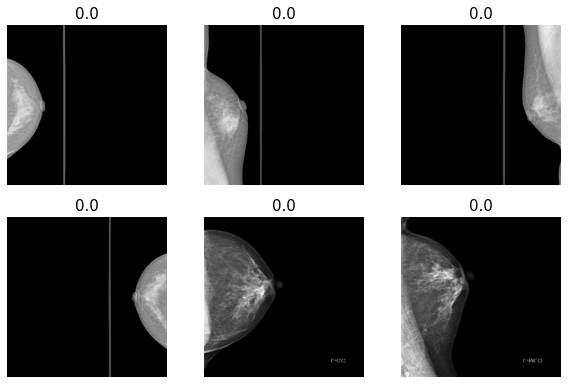

In [25]:
(image_batch, age_batch),label_batch  = next(iter(augment))
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3,3,i+1)
    # Cant rescale for these plots
    img = image_batch[i].numpy()
    img = img /img.max()
    img = img*255
    plt.imshow(img.astype("uint8"))
    label = label_batch[i]
    #print(label)
    #print(image_batch[i].numpy().astype("uint8"))
    plt.title(f'{label.numpy().squeeze()}', fontsize=15)
    plt.axis("off")

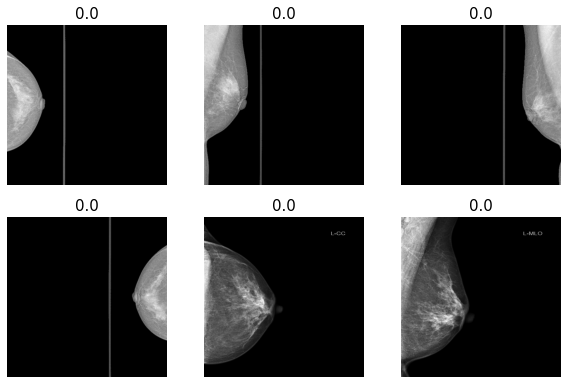

In [26]:
(image_batch, age_batch),label_batch  = next(iter(no_augment))
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3,3,i+1)
    # Cant rescale for these plots
    # Given I rescaled with log I have to bring the scale up by a factor of 50
    img = image_batch[i].numpy()
    img = img /img.max()
    img = img*255
    plt.imshow(img.astype("uint8"))
    label = label_batch[i]
    #print(image_batch[i].numpy().astype("uint8"))
    plt.title(f'{label.numpy().squeeze()}', fontsize=15)
    plt.axis("off")

In [27]:
_ = gc.collect()

# Modelling

In [28]:
def custom_loss(y_true,y_pred,beta = 1):
    eps = tf.constant([1e-5])
    
    
    y_pred = tf.clip_by_value(y_pred,0, 1)
    y_true_count = tf.math.reduce_sum(y_true)
    y_true_count = tf.cast(y_true_count, tf.float32)
    ctp = tf.math.reduce_sum(y_pred[y_true==1])
    cfn = tf.math.reduce_sum(y_true[y_pred < 0.6])
    cfp = tf.math.reduce_sum(y_pred[y_true==0])
    cfn = tf.cast(cfn, dtype = tf.float32)
    ctp = tf.cast(ctp, dtype = tf.float32)
    beta_squared = beta * beta
    #print(type(cfn),type(cfp))
    #print(cfn+cfp)
    recall = ctp/(ctp+cfn)
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * recall) / (beta_squared * c_precision + recall + eps)
        #print(recall,result)
        metric = tf.cast([2 - result],dtype = 'float32')
        #print(type(metric),metric)
        return metric[0][0]
    else:
        return 5.0

In [29]:
a = tf.constant([1,0,1,0])
b = tf.constant([0.2,0.3,0.4,0.5])
c = custom_loss(a,b)
c

<tf.Tensor: shape=(), dtype=float32, numpy=1.7000053>

In [42]:
######################
# Model
######################
#from keras_cv_attention_models import efficientnet
output_bias = None
def model(output_bias = None):

    with strategy.scope():
        #eff_net_v2 = hub.KerasLayer('https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2',trainable=False)
        inputs =  tf.keras.Input(shape=(512, 512, 3), name="input_layer",batch_size=CFG.batch_size) # shape of input image
        age = tf.keras.Input(shape = (1,), dtype = tf.float32)
        base_model = tf.keras.applications.efficientnet.EfficientNetB0(
                include_top = False,
                weights ='imagenet',
                input_shape = (512, 512, 3)
                #weights=None,
        )
        
        
        x = base_model(inputs) 
        
        
        j = layers.GlobalAveragePooling2D(name="global_average_pooling_x")(x)
        y = layers.GlobalMaxPooling2D(name="global_max_pooling_x")(x)
        z = layers.concatenate([j,y])
        combo = layers.Dense(64, activation = 'relu')(z)
        x = layers.AlphaDropout(0.2)(x)
        outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)(combo)
        #outputs = keras.layers.Dense(1, activation = ,bias_initializer=output_bias)(combo)
        model = tf.keras.Model((inputs,age), outputs)

        LOSS = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)

        f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.50),
       
        Precision = tf.keras.metrics.Precision(name='Precision')
        Recall = tf.keras.metrics.Recall(name='Recall')
        pf1 = pfbeta_tf
        pf1_thr = pfbeta_thr
        perda = custom_loss
        TP = tf.keras.metrics.TruePositives(thresholds = 0.5)
        FP = tf.keras.metrics.FalsePositives(thresholds = 0.5)
        TN = tf.keras.metrics.TrueNegatives(thresholds = 0.5)
        FN = tf.keras.metrics.FalseNegatives(thresholds = 0.5)
        METRICS = [pf1, pf1_thr, Precision, Recall,f1_score,'accuracy',TP,FP,TN,FN]

        #print(METRICS)
        model.compile(loss = LOSS,
                          optimizer=tf.keras.optimizers.Adam(0.001), # use Adam with default settings
                          metrics = METRICS)
        return model

In [43]:
a = model()

# Create the Dataset and Fit data

In [44]:
train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
0,2,10006,462822612,L,CC,0.685393,0,0,0,NaN,0,NaN,29,False,gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d...
1,2,10006,1459541791,L,MLO,0.685393,0,0,0,NaN,0,NaN,29,False,gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d...
2,2,10006,1864590858,R,MLO,0.685393,0,0,0,NaN,0,NaN,29,False,gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d...
3,2,10006,1874946579,R,CC,0.685393,0,0,0,NaN,0,NaN,29,False,gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d...
4,2,10011,220375232,L,CC,0.617978,0,0,0,0.0,0,NaN,21,True,gs://kds-45c1c1e2668e31c044f22903e1076a3b5915d...


In [ ]:
import warnings
oof_pred = []
oof_id = []
oof_true = []
for fold in range(0,3):
    with strategy.scope():
        print(fold)

        #################################
        # Split differently for each fold
        #################################

        Train, Valid, y_train, y_valid = train_test_split(train_csv[['image_path','age']], train_csv['cancer'], test_size=0.2, random_state = 42 + fold)
        
        ###############################
        # Upsample the train set
        ###############################
        df_1 = pd.DataFrame({'image_path':Valid['image_path'],'age': Valid['age'], 'cancer' : y_valid})
        print('The number of cancers in valid is :',df_1.cancer.value_counts())
        #if(df_1.cancer.value_counts()[1] <= 230):
        #    continue
        df = pd.DataFrame({'image_path':Train['image_path'],'age': Train['age'], 'cancer' : y_train})
        #print(df.cancer.value_counts())
        print('the number of cancer in the train ds is : ',df.cancer.value_counts())
        
        upsampled = resample(df[df['cancer'] == 0],
                 replace=True,
                 n_samples = int((len(df[df['cancer'] == 1]['cancer']))*5),
                 random_state=42)
        
        new_train = pd.concat([df[df['cancer'] == 1],upsampled])
        new_train = new_train.sample(frac=1).reset_index(drop=True)

        print('the number of cancer in the train ds after sample : ',new_train.cancer.value_counts())
        #print('The shape of the new df is :',new_train.head())
        Train = new_train['image_path']
        y_train = new_train['cancer']
        train_age = new_train['age']
        val_age = Valid['age']
        
        ############
        #Build DS
        ############

        cache = False
        train_age = np.asarray(train_age).astype('float32')
        val_age = np.asarray(val_age).astype('float32')
        train_ds = build_dataset(Train,train_age,labels =  y_train, cache=cache, 
                             batch_size=CFG.batch_size )
        
        valid_ds = build_dataset(Valid['image_path'],val_age,labels = y_valid, 
                             cache = cache,
                             batch_size=CFG.batch_size,
                            shuffle = False, augment = False, val = True)

        ###############
        # Class weights
        ###############
        print("Getting weights")
        neg = new_train['cancer'].value_counts()[0]
        pos = new_train['cancer'].value_counts()[1]
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weight = {0: weight_for_0, 1: weight_for_1*2}

        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))

        
        modelo = model()
        checkpoint_path = Path(f'/kaggle/working/Model_9_simple_NoAge{fold}.h5')
        #modelo.evaluate(valid_ds)
        early_stop = keras.callbacks.EarlyStopping(patience = 4,monitor = 'val_loss', verbose=1)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path, 
            verbose=1, 
            save_best_only = True)
        #########
        # Fit
        #########

        
        print("Model Fitting:")
        warnings.filterwarnings('ignore')
        history = modelo.fit(train_ds,
                        epochs = 20, 
                        validation_data =  valid_ds ,
                        batch_size= CFG.batch_size,
                        steps_per_epoch  = len(train_ds),
                        validation_steps  = int(len(valid_ds)/30),
                        callbacks=[early_stop,cp_callback],
                        class_weight=class_weight,
                        shuffle = True
                        ) 
        
        
        pred = modelo.predict(valid_ds)
        oof_pred.append(pred)
        oof_true.append(y_valid[:len(pred)])
        oof_id.append(Valid['image_path'])
        a = pred.squeeze()
        df = pd.DataFrame({'true' : y_valid[:len(pred)], 'pred' : a})
        thrs = np.arange(0,1,0.01)
        scores = []
        best_thr = 0
        best_score = 0
        for thr in thrs:
            a = pfbeta(df['true'],(df["pred"] > thr).astype(int))
            scores+=[a]
            if a > best_score:
                best_thr = thr
                best_score = a

        print(f'The best threshold seems to be: {best_thr}, with a best score of {best_score}')

        fig, ax = plt.subplots(figsize=(8,4))
        ax.fill_between(thrs, scores,
                        color='red', alpha=0.3, )
        ax.plot(thrs, scores, '-ok');
        ax.axvline(x=best_thr, color='blue', ls='--')
        ax.set_xlabel('Threshold');
        ax.set_ylabel('pF1');
        ax.set_title('Threshold Vs pF1');


0
The number of cancers in valid is : 0    10711
1      231
Name: cancer, dtype: int64
the number of cancer in the train ds is :  0    42837
1      927
Name: cancer, dtype: int64
the number of cancer in the train ds after sample :  0    4635
1     927
Name: cancer, dtype: int64
Getting weights
Weight for class 0: 0.60
Weight for class 1: 3.00
Model Fitting:
Epoch 1/20
43/43 [==============================] - 173s 3s/step - loss: 6.5003 - pF1: 0.2214 - pF1_thr: 0.2667 - Precision: 0.1657 - Recall: 0.7841 - f1_score: 0.2695 - accuracy: 0.2933 - true_positives_6: 409.7273 - false_positives_6: 2101.7727 - true_negatives_6: 297.6136 - false_negatives_6: 67.9773 - val_loss: 1.4563 - val_pF1: 0.0495 - val_pF1_thr: 0.0507 - val_Precision: 0.0273 - val_Recall: 1.0000 - val_f1_score: 0.0532 - val_accuracy: 0.0273 - val_true_positives_6: 7.0000 - val_false_positives_6: 249.0000 - val_true_negatives_6: 0.0000e+00 - val_false_negatives_6: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.456

In [ ]:
oof_pred = [item for sublist in oof_pred for item in sublist]
oof_true = [item for sublist in oof_true for item in sublist]
oof_id = [item for sublist in oof_id for item in sublist]
oof_id_1 = oof_id[:10880]
oof_id_2 = oof_id[10942: 21822]
oof_id_3 = oof_id[21884:32764]
ooo_id_final = oof_id_1 + oof_id_2 + oof_id_3
len(oof_pred)/3,len(ooo_id_final)/3 

In [ ]:
oof_pred_ = [item[0] for item in oof_pred]
oof_pred_[:2]

In [ ]:
oof_df = pd.DataFrame({'Pred' : oof_pred_, 
                       'True' : oof_true,
                       'ID' : ooo_id_final})

print(len(oof_df))
grouped_oof = oof_df.groupby(by=["ID"]).mean()
print(len(grouped_oof))

In [ ]:
grouped_oof.head()

In [ ]:
a = grouped_oof['Pred'].squeeze()
df = pd.DataFrame({'true' : grouped_oof['True'], 'pred' : a})
thrs = np.arange(0,1,0.01)
scores = []
best_thr = 0
best_score = 0
for thr in thrs:
    a = pfbeta(df['true'],(df["pred"] > thr).astype(int))
    scores+=[a]
    if a > best_score:
        best_thr = thr
        best_score = a

print(f'The best threshold seems to be: {best_thr}, with a best score of {best_score}')

fig, ax = plt.subplots(figsize=(8,4))
ax.fill_between(thrs, scores,
color='red', alpha=0.3, )
ax.plot(thrs, scores, '-ok');
ax.axvline(x=best_thr, color='blue', ls='--')
ax.set_xlabel('Threshold');
ax.set_ylabel('pF1');
ax.set_title('Threshold Vs pF1');

# GradCam

In [ ]:
print('Effnet')
for i,layer in enumerate(model.layers[1].layers[-3:]):#.layers):
    print(i, layer.name,layer.output_shape,layer.trainable, layer.output,'\n')
print(model.layers[1].inbound_nodes[-1].output_tensors)   
print('Resnet')
print(model.layers[2].inbound_nodes[-1].output_tensors)  
#for i,layer in enumerate(model.layers):#.layers):
#    print(i, layer.name,layer.output_shape,layer.trainable, layer.output,'\n')

In [ ]:
# tens de ter trainable True para poderes fazer isto
outputs = [layer.inbound_nodes[-1].output_tensors for layer in model.layers[1:3]]
print(outputs)
# Define a new model that generates the above output
vis_model = tf.keras.Model(model.input, outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers that will be used for visualization: ")
print(layer_names)

In [ ]:
def get_CAM(processed_image, actual_label, layer_position = -1, layer_pos_0 = 1):
    
    #model_grad = Model([model.inputs],
    #                   [model.get_layer(layer_name).output, model.output])
    
    model_grad = tf.keras.Model([model.inputs],
                       [model.layers[layer_pos_0].inbound_nodes[layer_position].output_tensors, model.output])
   
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # watch the conv_output_values
        tape.watch(conv_output_values)

        pred_prob = predictions
        
        # make sure actual_label is a float, like the rest of the loss calculation
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        
        # add a tiny value to avoid log of 0
        smoothing = 0.00001 
        
        # Calculate loss as binary cross entropy
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")
    
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    # weight the convolution outputs with the computed gradients
    for i in range(512): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [ ]:
def show_sample( image_csv ,img_ind = 1):
    
    sample_image = cv2.imread(image_csv['new_image_path'][img_ind])
    sample_label = image_csv['cancer'][img_ind]
    #print(type(sample_image))
    sample_image_log = np.log(sample_image)
    sample_image_log = np.clip(sample_image_log, 0, 255)
  
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    
    activations = vis_model.predict(sample_image_processed)
    
    pred_label = model.predict(sample_image_processed)[0][0]
    
    sample_activation = activations[0][0,:,:,16]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    
    converted_img = sample_image.astype('float32')
    #print(sample_image.dtype,heatmap.dtype,converted_img.max())
    super_imposed_image = cv2.addWeighted(sample_image, 1, heatmap ,1, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return 0

In [ ]:
df_1['new_image_path'] = Caminho_base +'/'+ df_1.image_path.apply(lambda x : 
                                    '/'.join(x.split('/')[5:]))

In [ ]:
#df_1 = df_1.reset_index()
df_1.new_image_path[1]

In [ ]:
for i in range(150):
    if(df_1.cancer[i] == 1):
        print(i)

In [ ]:
show_sample( df_1,114 )

# Fine Tuning seems to result in Over Fitting 

In [ ]:
"""model.load_weights(f'/kaggle/working/Model_4_TPU_FT_fold{fold}.h5')
    
    with strategy.scope():    
        base_model.trainable = True
        for layer in base_model.layers[:-15]:
            layer.trainable = False # freeze all of the layers except for the last 10


        base_model_3.trainable = True
        for layer in base_model_3.layers[:-15]:
            layer.trainable = False # freeze all of the layers except for the last 10

    Precision = tf.keras.metrics.Precision(name='Precision')
    Recall = tf.keras.metrics.Recall(name='Recall')
    pf1 = pfbeta_tf
    pf1_thr = pfbeta_thr
    METRICS = [pf1, pf1_thr, Precision, Recall]
    model.compile(loss = LOSS,
                      optimizer=tf.keras.optimizers.Adam(0.0001), # use Adam with default settings
                      metrics = METRICS)
    print(len(model.trainable_variables))
    
    
    checkpoint_path = Path(f'/kaggle/working/Model_4_TPU_FT_fold{fold}.h5')

    early_stop = keras.callbacks.EarlyStopping(patience = 3,monitor='Recall', 
        verbose=1,)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_best_only = True)

    # Fit
    history_2 = model.fit(train_ds,
                        epochs = 5, # fit for 5 epochs to keep experiments quick
                        validation_data = valid_ds,
                        steps_per_epoch = len(train_ds),
                        validation_steps = int(0.3*len(valid_ds)),
                        callbacks=[early_stop,cp_callback],
                        initial_epoch = history.epoch[-1],
                         shuffle = True,
                         class_weight=class_weight) """

In [ ]:
"""model.load_weights(f'/kaggle/working/Model_4_TPU_FT_fold0.h5')
    
with strategy.scope():    
    base_model.trainable = True
    for layer in base_model.layers[:-15]:
        layer.trainable = False # freeze all of the layers except for the last 10


    base_model_3.trainable = True
    for layer in base_model_3.layers[:-15]:
        layer.trainable = False # freeze all of the layers except for the last 10

    Precision = tf.keras.metrics.Precision(name='Precision')
    Recall = tf.keras.metrics.Recall(name='Recall')
    pf1 = pfbeta_tf
    pf1_thr = pfbeta_thr
    METRICS = [pf1, pf1_thr, Precision, Recall]
    model.compile(loss = LOSS,
                      optimizer=tf.keras.optimizers.Adam(0.0001), # use Adam with default settings
                      metrics = METRICS)
    print(len(model.trainable_variables))
    
    
checkpoint_path = Path(f'/kaggle/working/Model_4_TPU_FT_fold{fold}.h5')

early_stop = keras.callbacks.EarlyStopping(patience = 3,monitor='Recall', 
        verbose=1,)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_best_only = True)

    # Fit
history_2 = model.fit(train_ds,
                        epochs = 5, # fit for 5 epochs to keep experiments quick
                        validation_data = valid_ds,
                        steps_per_epoch = len(train_ds),
                        validation_steps = int(0.3*len(valid_ds)),
                        callbacks=[early_stop,cp_callback],
                        initial_epoch = history.epoch[-1],
                         shuffle = True,
                         class_weight=class_weight) 

    """